# Bioimaging 2

#### Check working directory.

In [1]:
#Package
import os

#Command
os.getcwd()

'/home/howsetya/workspace/Bioimage2'

There are 4 directories of data, namely 2 sets of training and 2 sets of challenge datasets with the following relative path:
1. ./Images/training_BF-C2DL-HSC/01/subset/*.tif
2. ./Images/training_BF-C2DL-HSC/02/subset/*.tif
3. ./Images/challenge_BF-C2DL-HSC/01/subset/*.tif
4. ./Images/challenge_BF-C2DL-HSC/02/subset/*.tif

These are all subsets of the real complete dataset to save time in going through all the data. Each contains around 20% the amount of the complete data (0.2 * ~1700 = ~350 images).

Additionally, the training 01 dataset is further subset to get an even fewer images in the path
./Images/training_BF-C2DL-HSC/01/subset2/*.tif

#### Load Images

First, define a function to load image files and put them in a data frame.

In [2]:
#Package
import glob, re
import pandas as pd
from skimage.io import imread, imshow, show

#Function
def load_imgs(path):
    files_img = glob.glob(path)
    files_img.sort()
    df_img = pd.DataFrame(columns=['FileName','Image'])
    for file in files_img:
        filename = re.sub(".*/", "", file[:-4])
        img = imread(file) #tifffile plugin for loading compressed tiffs requires imagecodecs
        df_img.loc[len(df_img)] = [filename,img]
        # print(file) #to show progress
        # imshow(img) #to show image
        # show()
    return(df_img)

In [3]:
#Set path
#This subset2 folder contains even fewer images than the one mentioned above 
path = ('./Images/training_BF-C2DL-HSC/01/subset2/*.tif')

#Load all images in the directory of the path
img_df = load_imgs(path)

#### Inspection

In [4]:
#Check the data frame
img_df.shape
img_df.iloc[0:4]

,FileName,Image
0,t0001,"[[132, 132, 131, 133, 132, 131, 133, 134, 132,..."
1,t0040,"[[132, 132, 132, 132, 131, 133, 132, 134, 133,..."
2,t0080,"[[132, 132, 131, 132, 132, 130, 131, 133, 133,..."
3,t0100,"[[131, 133, 133, 131, 132, 131, 131, 131, 132,..."


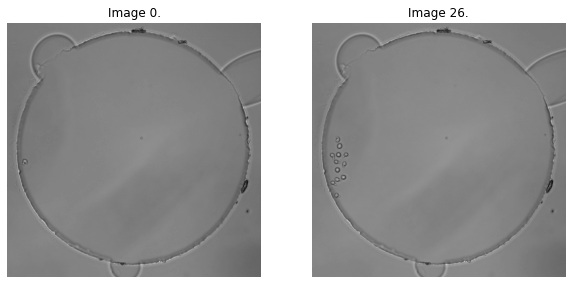

In [95]:
#Package
import matplotlib.pyplot as plt

#Check the images
n1 = 0 # first image
n2 = 26 # last image
fig, ax = plt.subplots(1,2,figsize=(10,10))
[ax.set_axis_off() for ax in ax.ravel()]
ax[0].imshow(img_df.iloc[n1,1],cmap='gray')
ax[0].set_title(f'Image {n1}.')
ax[1].imshow(img_df.iloc[n2,1],cmap='gray')
ax[1].set_title(f'Image {n2}.')
plt.show()

#### Analysis

Just to get an idea of how the images of the other sets look like, one arbitrary image is taken from each directory and plotted.

In [6]:
#Load just one image from each directory.
tr1_ss = imread('./Images/training_BF-C2DL-HSC/01/subset/t1400.tif')
tr2_ss = imread('./Images/training_BF-C2DL-HSC/02/subset/t1400.tif')
ch1_ss = imread('./Images/challenge_BF-C2DL-HSC/01/subset/t1400.tif')
ch2_ss = imread('./Images/challenge_BF-C2DL-HSC/02/subset/t1400.tif')

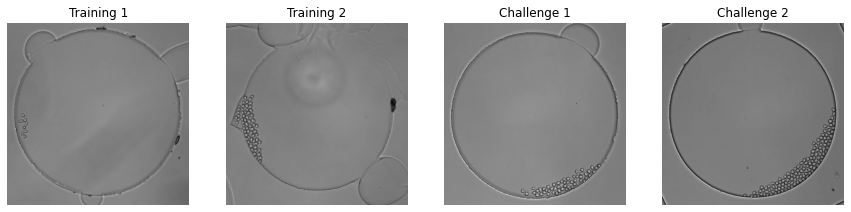

In [96]:
#Check the image
fig, ax = plt.subplots(1,4, figsize=(15,15))
[ax.set_axis_off() for ax in ax.ravel()]
ax[0].imshow(tr1_ss,cmap='gray')
ax[0].set_title('Training 1')
ax[1].imshow(tr2_ss,cmap='gray')
ax[1].set_title('Training 2')
ax[2].imshow(ch1_ss,cmap='gray')
ax[2].set_title('Challenge 1')
ax[3].imshow(ch2_ss,cmap='gray')
ax[3].set_title('Challenge 2')
plt.show()

As can be seen here, the wells seem to be nicely reasonably rounded except for one dataset (Training2). And glancing intuitively here, the images lack contrast, clearly demonstrated by the dominating grey colour over all the images from the background up to the cells themselves. The histogram also indicate the difficulty that would be encountered should a manual thresholding is to be done.

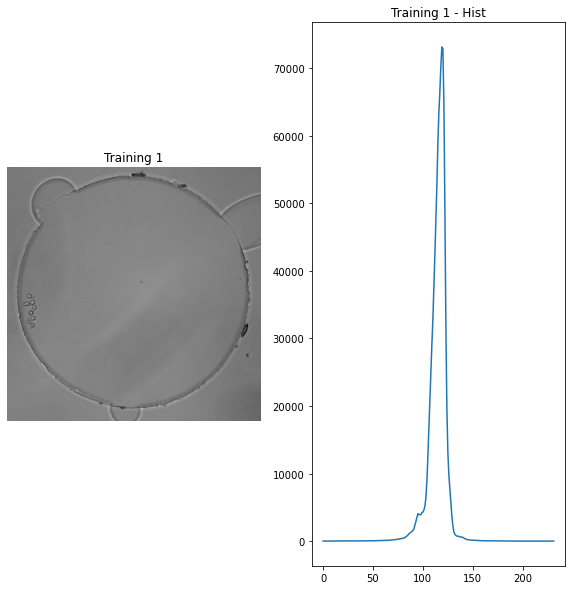

In [97]:
#Package
from skimage import exposure

hist, hist_centers = exposure.histogram(tr1_ss)

#Plot
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(tr1_ss,cmap='gray')
ax[0].set_title('Training 1')
ax[0].axis('off')
ax[1].plot(hist)
ax[1].set_title('Training 1 - Hist')
plt.show()

Efforts to improve contrast are therefore attempted by automatic thresholding using different methods available in skimage.

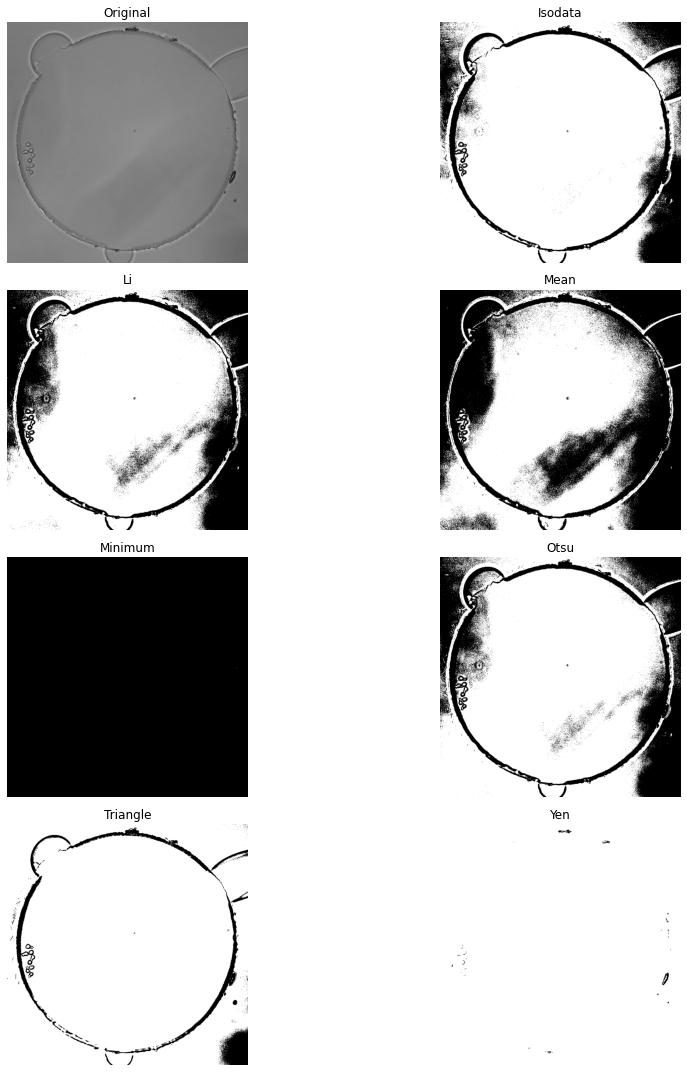

In [9]:
#Package
from skimage.filters import try_all_threshold

#Plot
fig, ax = try_all_threshold(tr1_ss, figsize=(15, 15), verbose=False)
plt.show()

The Triangle thresholding method seems promising, at least for the one arbitrary example here.

This is then tried to the small subset that has been loaded before (Training 1 Subset 2). And the result seems fine enough, as seen below.

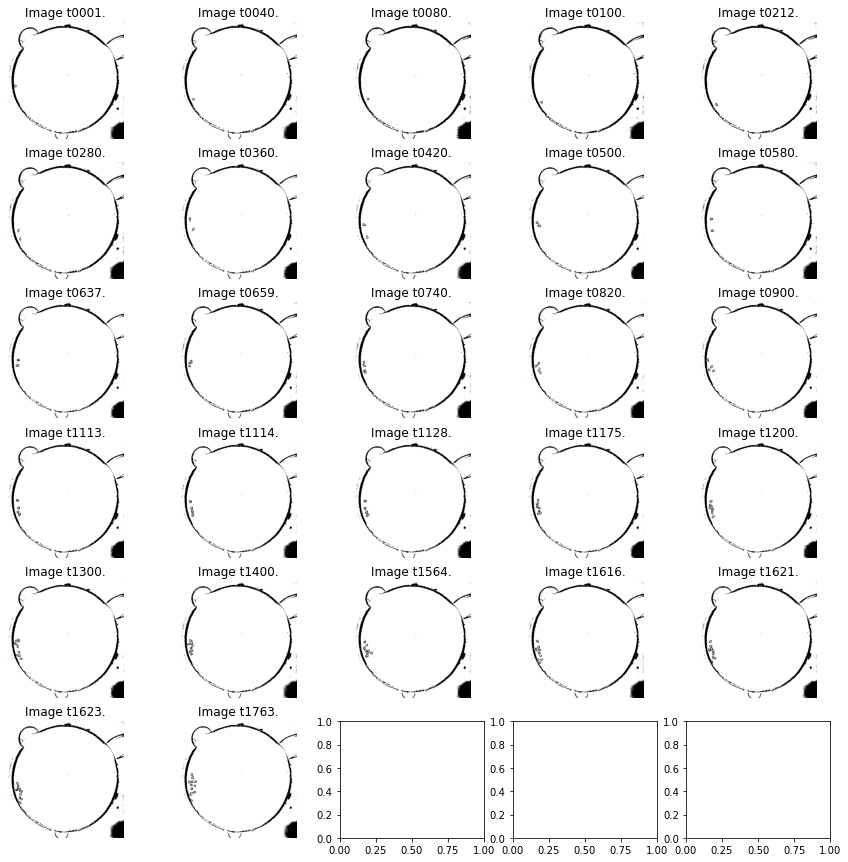

In [10]:
#Package
from skimage.filters import threshold_triangle as tri

#Overview
fig, ax = plt.subplots(6,5,figsize=(15,15))
ax = ax.ravel()
for n in range(len(img_df)):
    thr = tri(img_df.iloc[n,1]) 
    binary_img = img_df.iloc[n,1] > thr
    title = img_df.iloc[n,0]
    ax[n].imshow(binary_img, cmap='gray')
    ax[n].set_title(f'Image {title}.')
    ax[n].axis('off')
    
#Alternatively, larger images
#for n in range(1,len(train1_subs2),35):
#    thr = tri(train1_subs2.iloc[n,1]) 
#    binary_img = train1_subs2.iloc[n,1] > thr
#    title = train1_subs2.iloc[n,0]
#    fig, ax = plt.subplots(figsize=(8,8))
#    plt.imshow(binary_img, cmap='gray')
#    plt.title(f'Image {title}.')
#    show()

However, running it for other subset proves that this seems to be problematic.

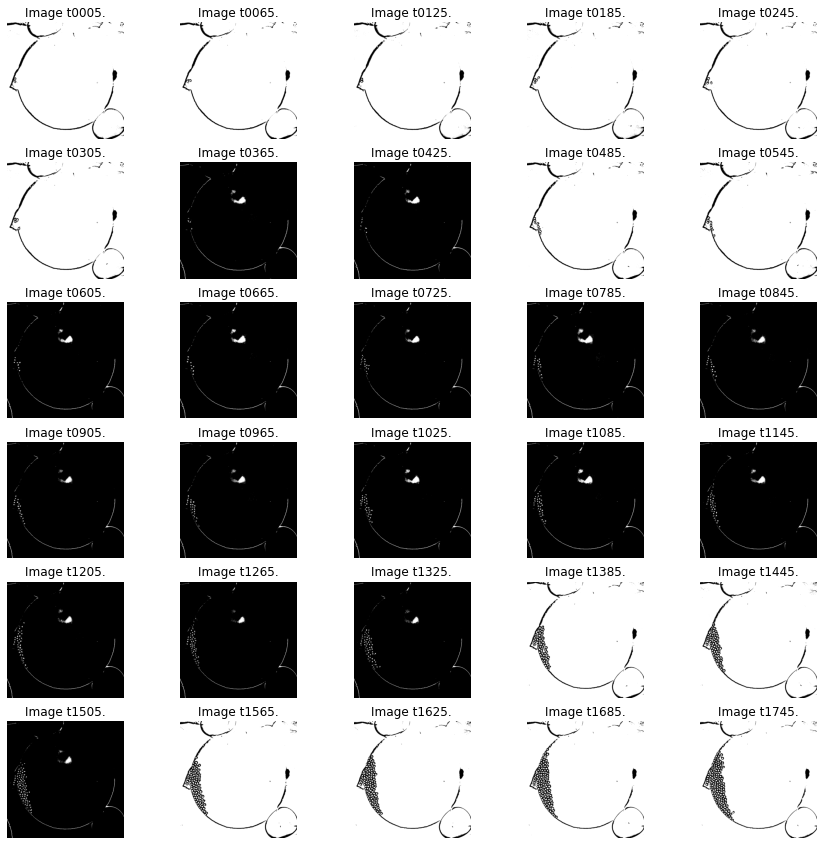

In [11]:
#Try other (sub)dataset, Training 2.
path2 = ('./Images/training_BF-C2DL-HSC/02/subset/*.tif')
img_df2 = load_imgs(path2)

#Overview
fig, ax = plt.subplots(6,5,figsize=(15,15))
ax = ax.ravel()
k=0
for n in range(1,len(img_df2),12): #Just sample some images
    thr = tri(img_df2.iloc[n,1]) 
    binary_img = img_df2.iloc[n,1] > thr
    title = img_df2.iloc[n,0]
    ax[k].imshow(binary_img, cmap='gray')
    ax[k].set_title(f'Image {title}.')
    ax[k].axis('off')
    k=k+1

The gray level pixel values of some images seem to be "flipped" after thresholding. This problem also persist through the other (sub)datasets. 

Inspecting the difference between the "flipped" image and "non-flipped" image seems that no major difference can be observed. However since [the triangle method constructs a line between the histogram peak and the farthest end of the histogram](https://www.kitware.com/histogram-based-thresholding/), it may probably happen that the line is constructed to the opposite ends of the histogram, depending on the image. On one image it may be directed toward 0, and oppositely on other image, depending on the longest distance to whichever end (zero or max).

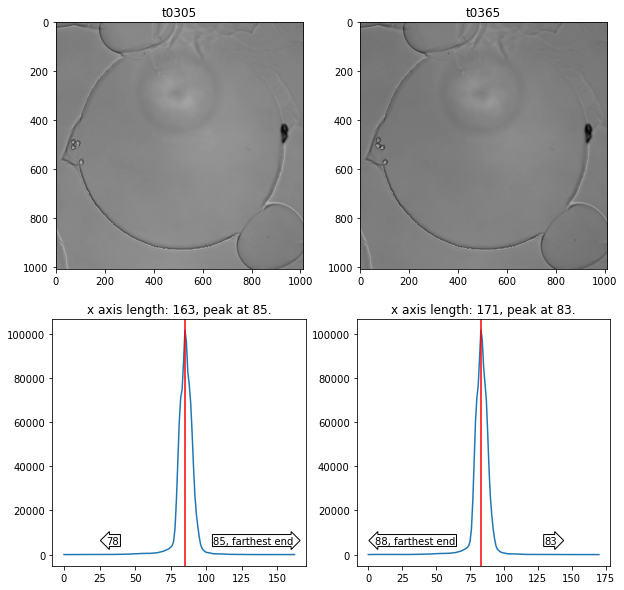

In [89]:
flip = img_df2[img_df2["FileName"] == 't0305']
nflip = img_df2[img_df2["FileName"] == 't0365']
hist, hist_centers = exposure.histogram(flip.iloc[0,1])
nhist, nhist_centers = exposure.histogram(nflip.iloc[0,1])

#Get peak position
import numpy as np
flipm = np.argmax(hist)
nflipm = np.argmax(nhist)

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.ravel()
ax[0].imshow(flip.iloc[0,1], cmap='gray')
ax[0].set_title(flip.iloc[0,0])
ax[1].imshow(nflip.iloc[0,1], cmap='gray')
ax[1].set_title(nflip.iloc[0,0])
ax[2].plot(hist)
ax[2].axvline(x=flipm, color='r')
ax[2].text(105, 5000, "85, farthest end", bbox=dict(boxstyle="rarrow,pad=0.1", fc="w", ec="k"))
ax[2].text(30, 5000, "78", bbox=dict(boxstyle="larrow,pad=0.1", fc="w", ec="k"))
ax[2].set_title(f'x axis length: {len(hist)}, peak at {flipm}.')
ax[3].plot(nhist)
ax[3].text(130, 5000, "83", bbox=dict(boxstyle="rarrow,pad=0.1", fc="w", ec="k"))
ax[3].text(5, 5000, "88, farthest end", bbox=dict(boxstyle="larrow,pad=0.1", fc="w", ec="k"))
ax[3].axvline(x=nflipm, color='r')
ax[3].set_title(f'x axis length: {len(nhist)}, peak at {nflipm}.')
plt.show()

And indeed this is the case which makes the triangle thresholding method goes awry. To mitigate this, 

163

In [ ]:
#Put into dataframe
train1_subs2['Tri']=''
for n in range(len(train1_subs2)):
    thr = tri(train1_subs2.iloc[n,1]) 
    binary_img = train1_subs2.iloc[n,1] > thr
    train1_subs2.iloc[n,2] = [binary_img]

In [ ]:
#Check dataframe
train1_subs2.iloc[0:4]

To remove the outlines of the well where the cells proliferate, a mask is manually made for the well in each dataset. All the wells looks well rounded and only ever so slightly off-center. So a simple circle masking would work for all dataset except for the Training 2 dataset. Nevertheless, a bespoke masking option might as well be available for other datasets.

In [ ]:
#Package
import numpy as np
from skimage import draw

#Function
def mask_set(image_arr,set=''):
    image_arr_copy = image_arr
    mask = np.ones(shape=image_arr.shape[0:2], dtype="bool")
    if set == 'tr1': #for training 1 dataset
        rr, cc = draw.disk((500, 500), 448)
        mask[rr, cc] = False
    elif set == 'tr2': #for training 2 dataset
        #rr, cc = draw.polygon((560,328,766),(25,117,178))
        rr, cc = draw.ellipse(455,168,80,180,rotation=np.deg2rad(45)) # better than polygon
        mask[rr, cc] = False
        rr1, cc1 = draw.disk((500, 500), 420)
        mask[rr1,cc1] =False
    elif set == 'ch1': #for challenge 1 dataset
        rr, cc = draw.disk((510, 510), 460)
        mask[rr, cc] = False
    elif set == 'ch2': #for challenge 2 dataset
        rr, cc = draw.disk((505, 500), 470)
        mask[rr, cc] = False
    else:
        print('Specify set (tr1, tr2, ch1, or ch2).')
    image_arr_copy[mask] = 1
    return(image_arr_copy)

In [ ]:
#Apply masking and put into dataframe
train1_subs2['Masked']=''
for n in range(1,len(train1_subs2),35):
    image_arr = train1_subs2.iloc[n,2]
    masked = mask_set(image_arr,set='ch1') #Change set accordingly 
    train1_subs2.iloc[n,3] = [masked]
    plt.figure(figsize = (8,8))
    plt.imshow(masked,cmap='gray')
    show()